In [1]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI')

import scipy.io as sio
from scipy.stats import norm
from scipy.stats import multivariate_normal
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
from src.RL_functions.generate_one_synthetic_time_series import generate_one_synthetic_time_series
from src.RL_functions.kalman_filter import KalmanFilter
import copy

In [2]:
# Generate synthetic data
# components = ['level','fourrier','ar']
components = ['level','ar']
time_step_interval = 1

AR_param_var = 5**2
AR_param_phi = 0.9
hyperparameters = {'level': {'process_error_var': 0.0},
                #    'fourrier': {'period': 52, 'process_error_var': 0},
                   'ar': {'phi': AR_param_phi, 'process_error_var': AR_param_var},
                   'observation': {'error': 1e-6}}
x_init = {'mu': np.array([5, -0.0621]), \
          'var': np.diag([0.00531, 6.36E-05])}
# x_init = {'mu': np.array([5, np.sqrt(AR_param_var) * 5, 0, -0.0621]), \
#           'var': np.diag([0.00531,1e-12, 1e-12, 6.36E-05])}
num_steps = 625

AR_stationary_var = hyperparameters['ar']['process_error_var'] / (1 - hyperparameters['ar']['phi']**2)

# Set seed
# np.random.seed(0) # Same seed as in Canari
# np.random.seed(4) # False alarm seed: 4, 5, 8
# np.random.seed(9) # Not clean detection seed: 9
np.random.seed(1)

data_generator = generate_one_synthetic_time_series(components = components, 
                                                    time_step_interval = time_step_interval, 
                                                    hyperparameters = hyperparameters, 
                                                    num_steps = num_steps,
                                                    x_init = x_init)

# # ts = data_generator.generate_time_series()
# data_generator.plot()

In [3]:
# Generate periodic pattern
components_P = ['level','fourrier']

hyperparameters_P = {'level': {'process_error_var': 0.0},
                   'fourrier': {'period': 52, 'process_error_var': 0},
                   'observation': {'error': 0}}
x_init_P = {'mu': np.array([0, np.sqrt(AR_param_var) * 5, 0]), \
          'var': np.diag([0, 1e-12, 1e-12])}

data_generator_P = generate_one_synthetic_time_series(components = components_P, 
                                                    time_step_interval = time_step_interval, 
                                                    hyperparameters = hyperparameters_P, 
                                                    num_steps = num_steps,
                                                    x_init = x_init_P)

# # ts = data_generator.generate_time_series()
# data_generator_P.plot()

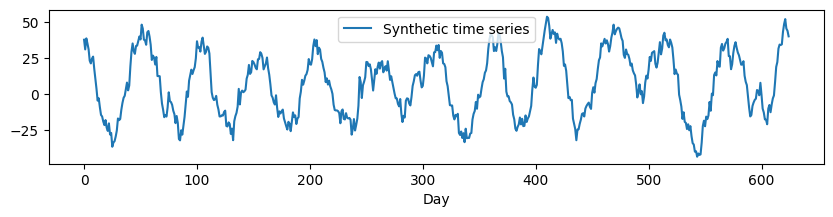

In [4]:
# Add periodic patten
data_generator.time_series['y'] = (np.array(data_generator.time_series['y']) + np.array(data_generator_P.time_series['y'])).tolist()

data_generator.plot()

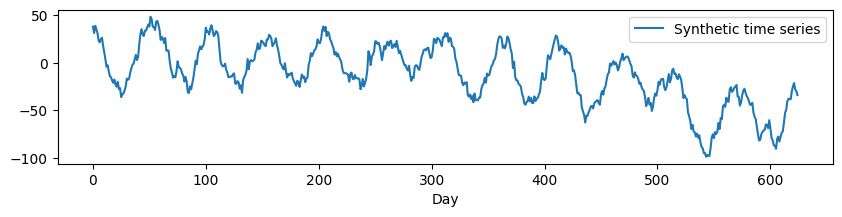

In [5]:
# Add anomaly
anm_pos = 300
anm_mag = - (np.sqrt(AR_stationary_var)*1) / 50
# anm_mag = 0
LL_anm_mag = -20
for i in range(num_steps):
    # Add anomaly 
    if i >= anm_pos:
        data_generator.time_series['y'][i] += anm_mag * (i - anm_pos)
    # if i >= anm_pos:
    #     data_generator.time_series['y'][i] += LL_anm_mag
data_generator.plot()

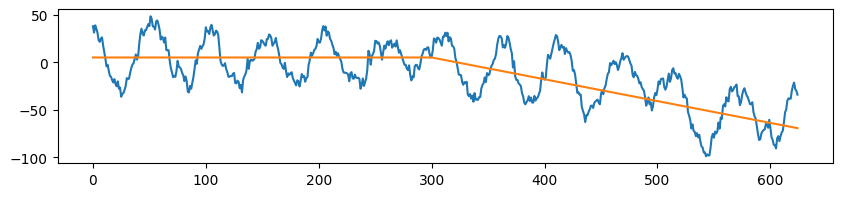

In [6]:
# Plot data_generator.time_series['y'] and its trend
level_baseline = np.zeros_like(data_generator.time_series['y']) + x_init['mu'][0]
for i in range(num_steps):
    if i >= anm_pos:
        level_baseline[i] += anm_mag * (i - anm_pos)

plt.figure(figsize=(10, 2))
plt.plot(data_generator.time_series['y'], label='y')
plt.plot(level_baseline, label='trend_baseline')

In [7]:
# from src.RL_functions.base_drift_candidate_model import base_drift_candidate_model
from src.RL_functions.actor_critic_kf import *
components = ['trend','fourrier', 'ar']
components_d = ['trend', 'ar']

hyperparameters = {'trend': {'process_error_var': 1e-7},
                    'fourrier': {'period': 52, 'process_error_var': 0},
                    'ar': {'phi': AR_param_phi, 'process_error_var': AR_param_var},
                    'observation': {'error': 1e-6}}

x_init = {'mu': np.array([5, 0, np.sqrt(AR_param_var) * 5, 0, -0.0621]), \
            'var': np.diag([1e-6, 5E-5, 1e-12, 1E-12, 6.36E-05])}

kf = KalmanFilter(components = components, time_step=time_step_interval, hyperparameters = hyperparameters)

baseline_process_error_var_all = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
# baseline_process_error_var_all = [1e-3]

y_LL_all = []
trigger_pos = []

x_last_step = x_init

mv_normal_x_all = []
scale_factors_all = []

intervene = False
intervention_state = None

LL_mu, LT_mu, AR_mu, y_pred_mus = [], [], [], []
LL_var, LT_var, AR_var, y_pred_vars = [], [], [], []

for i in range(num_steps):

    # if p_a0 < 0.5:
    if i in [320, 360, 420, 500]:
        intervene = True
        trigger_pos.append(i)

        intervention_state = copy.deepcopy(x_last_step)
        # intervention_state['mu'][1] = x_init['mu'][1] + anm_mag
        # intervention_state['mu'][0] = x_init['mu'][0] + anm_mag * (i - 1 - anm_pos)
        # intervention_state['mu'][2] = x_last_step['mu'][2]
        # intervention_state['mu'][3] = x_last_step['mu'][3]
        intervention_state['var'][1,1] += 0.1

    else:
        intervene = False

    x_pred, y_pred, x_last_step = actor(kf, x_last_step, intervene, intervention_state, data_generator.time_series['y'][i])
    y_LL = np.log(norm.pdf(data_generator.time_series['y'][i], loc=y_pred['mu'], scale=np.sqrt(y_pred['var'])))
    y_LL_all.append(y_LL)
    

    LL_mu.append(x_pred['mu'][0])
    LT_mu.append(x_pred['mu'][1])
    AR_mu.append(x_pred['mu'][-1])
    LL_var.append(x_pred['var'][0,0])
    LT_var.append(x_pred['var'][1,1])
    AR_var.append(x_pred['var'][-1,-1])
    y_pred_mus.append(y_pred['mu'].item())
    y_pred_vars.append(y_pred['var'].item())


Total reward: -1886.844985839135


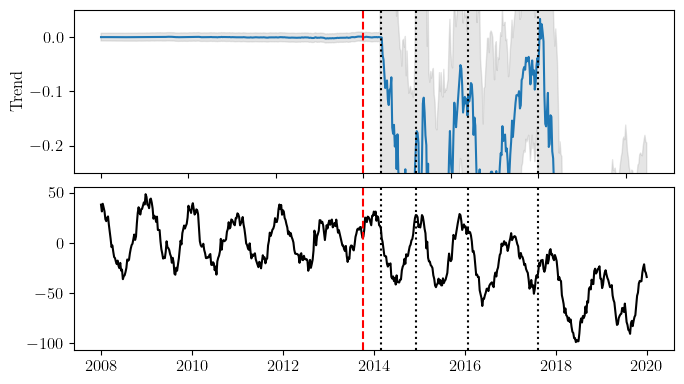

In [9]:
# Plot prediction
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
params = {'text.usetex' : True,
          'font.size' : 12,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params) 
plt.rcParams["figure.autolayout"] = True

plt.rcParams["figure.autolayout"] = True
fig = plt.figure(figsize=(7, 4))
gs = gridspec.GridSpec(2, 1)
ax0 = plt.subplot(gs[1])
ax1 = plt.subplot(gs[0])
# ax2 = plt.subplot(gs[2])
# ax3 = plt.subplot(gs[3])

############ Base model ############
# ax0.plot(data_generator.time_series['timesteps'], level_baseline, '--', color='gray', label='True levels')
# ax0.plot(data_generator.time_series['timesteps'], y_pred_mus, label='Prediction')
# ax0.fill_between(data_generator.time_series['timesteps'], np.array(y_pred_mus)-np.sqrt(y_pred_vars), np.array(y_pred_mus)+np.sqrt(y_pred_vars),color='gray', alpha=0.2)
# ax0.plot(data_generator.time_series['timesteps'], LL_mu)
# ax0.fill_between(data_generator.time_series['timesteps'], np.array(LL_mu)-np.sqrt(LL_var), np.array(LL_mu)+np.sqrt(LL_var),color='gray', alpha=0.2)
ax0.plot(data_generator.time_series['timesteps'], data_generator.time_series['y'],'k', label='True observation')
if anm_mag != 0:
    ax0.axvline(x=anm_pos, color='r', linestyle='--', label='Anomaly')
if len(trigger_pos) > 0:
    for trigger in trigger_pos:
        ax0.axvline(x=trigger, color='k', linestyle=':')
# ax0.legend(loc='lower left', ncol = 2)
# ax0.set_ylabel('Level')
# ax0.set_xticklabels([])
# Set x ticks
ax0.set_xticks([0, 104, 208, 312, 416, 520, 624])
ax0.set_xticklabels([2008, 2010, 2012, 2014, 2016, 2018, 2020])

ax1.plot(data_generator.time_series['timesteps'], LT_mu, label='Prediction')
ax1.fill_between(data_generator.time_series['timesteps'], np.array(LT_mu)-np.sqrt(LT_var), np.array(LT_mu)+np.sqrt(LT_var),color='gray', alpha=0.2)
if anm_mag != 0:
    ax1.axvline(x=anm_pos, color='r', linestyle='--', label='Anomaly')
if len(trigger_pos) > 0:
    for trigger in trigger_pos:
        ax1.axvline(x=trigger, color='k', linestyle=':')
ax1.set_ylabel('Trend')
ax1.set_xticklabels([])
ax1.set_yticks([-0.2, -0.1, 0])
ax1.set_ylim(-0.25, 0.05)

# ax2.plot(data_generator.time_series['timesteps'], AR_mu, label='Prediction')
# ax2.fill_between(data_generator.time_series['timesteps'], np.array(AR_mu)-np.sqrt(AR_var), np.array(AR_mu)+np.sqrt(AR_var),color='gray', alpha=0.2)
# if anm_mag != 0:
#     ax2.axvline(x=anm_pos, color='r', linestyle='--', label='Anomaly')
# if len(trigger_pos) > 0:
#     for trigger in trigger_pos:
#         ax2.axvline(x=trigger, color='k', linestyle=':')
# ax2.set_ylabel('Residual')
# ax2.set_xticklabels([])
# ax2.set_xticks([0, 104, 208, 312, 416, 520, 624])
# # ax2.set_xticks([0, 104, 208, 312, 416, 520, 624])
# # ax2.set_xticklabels([2008, 2010, 2012, 2014, 2016, 2018, 2020])
# ax2.set_yticks([-50, -25, 0, 25])
# ax2.set_ylim(-65, 27)


# ax3.plot(data_generator.time_series['timesteps'], y_LL_all, label='LL')
# if anm_mag != 0:
#     ax3.axvline(x=anm_pos, color='r', linestyle='--', label='Anomaly')
# if len(trigger_pos) > 0:
#     for trigger in trigger_pos:
#         ax3.axvline(x=trigger, color='k', linestyle=':')
# ax3.set_ylabel('Reward')
# ax3.set_xticks([0, 104, 208, 312, 416, 520, 624])
# ax3.set_xticklabels([2008, 2010, 2012, 2014, 2016, 2018, 2020])

plt.tight_layout(h_pad=0.5, w_pad=0.1)
plt.savefig('ts14.png', dpi=300)

print('Total reward:', np.sum(y_LL_all))